<a href="https://colab.research.google.com/github/theostoican/Guided-Research/blob/main/finetuning_odin_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract pretrained ResNet on ImageNet

In [ ]:
import torch
from torchvision import transforms as pth_transforms

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

!pip install timm
!pip install torchvision
import timm
import requests
from torchvision import models
import torchvision.transforms as transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.train()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 15.0 MB/s 
     |████████████████████████████████| 163 kB 86.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
!pip install torchinfo
from torchinfo import summary
# summary(vitb16, (1, 3, 224, 224))

image_size = 256

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# MLP for predictor and projector

In [ ]:
import torch.nn.functional as F

# MLP class for projector and predictor

def MLP(dim=512, projection_size=256, hidden_size=4096):
    return nn.Sequential(
        nn.Linear(dim, hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_size, projection_size)
    )

# The whole Odin architecture

## Various helpers

In [ ]:
import random
from copy import deepcopy

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from torch import nn

def set_requires_grad(model, val):
    for p in model.parameters():
        p.requires_grad = val

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

class RandomApply(torch.nn.Module):
    def __init__(self, fn, p):
        super().__init__()
        self.fn = fn
        self.p = p
    def forward(self, x):
        if random.random() > self.p:
            return x
        return self.fn(x)

## Wrapper class for the thata, tau, and csi encoders.

In [ ]:
class NetWrapper(torch.nn.Module):
  def __init__(self, net):
    super().__init__()
    self.net = net
    self.projector = MLP()
    self.activation = {}
    self.hook_registered = False

  def _register_hook(self):
    self.net.layer4.register_forward_hook(self._get_activation('h'))

  def _get_activation(self, name):
    def hook(model, input, output):
        self.activation[name] = output.detach()
    return hook

  def get_representation(self, inputs):
    if not self.hook_registered:
      self._register_hook()
    _ = self.net(inputs)
    return self.activation['h']

  def get_masks(self, inputs):
    features = self.get_representation(inputs)

    masks = []

    for feature in features:

      num_channels, num_x, num_y = feature.shape
      normalized_feature = feature.reshape(num_channels, num_x * num_y)
      normalized_feature = normalized_feature.T.cpu()
      nn.functional.normalize(normalized_feature, p = 2, dim = 1)

      kmeans = KMeans(
        init="random",
        n_clusters=2,
        n_init=10,
        max_iter=1000,
        random_state=42)
    
      labels = kmeans.fit_predict(normalized_feature)
      labels = labels.reshape(1, num_x, num_y)

      # Extend the mask to the original size of the image, so that we can feed
      # both the image and the mask through the image augmentation pipeline.
      # This is necessary such that both the image and the mask are augmented
      # in the exact same way (due to the inherent randomness of augmentation).
      labels = nn.functional.interpolate(torch.FloatTensor(labels).unsqueeze(0),
                                    size=(image_size, image_size), mode="nearest")[0]

      expanded_mask = torch.FloatTensor(labels).repeat(inputs[0].shape[0], 1, 1).to(device)

      masks.append(expanded_mask)

    masks = torch.stack(masks)
    return masks
      

  def forward(self, inputs, masks_obj1, masks_obj2):
    features = self.get_representation(inputs)

    mask_pooled_features_obj1 = []
    mask_pooled_features_obj2 = []

    for idx, feature in enumerate(features):
      num_channels, num_x, num_y = feature.shape
      feature = feature.reshape(num_channels, num_x * num_y)

      # The mask was previously resized to the initial size of images so that
      # it can be fed to the augmentation pipeline. Now, we want to apply the
      # masks to the feature output by the network, so we have to resize the 
      # masks to their original sizes in order to be able to apply them.
      resized_mask_obj1 = nn.functional.interpolate(masks_obj1[idx][0].unsqueeze(0).unsqueeze(0),
                                    size=(num_x, num_y), mode="nearest")[0]
      resized_mask_obj2 = nn.functional.interpolate(masks_obj2[idx][0].unsqueeze(0).unsqueeze(0),
                                    size=(num_x, num_y), mode="nearest")[0]


      resized_mask_obj1 = resized_mask_obj1.repeat(num_channels, 1, 1)
      resized_mask_obj2 = resized_mask_obj2.repeat(num_channels, 1, 1)

      resized_mask_obj1 = resized_mask_obj1.reshape(num_channels, num_x * num_y)
      resized_mask_obj2 = resized_mask_obj2.reshape(num_channels, num_x * num_y)

      mask_pooled_feature_obj1 = torch.mean(torch.mul(feature, resized_mask_obj1), dim=(1))
      mask_pooled_feature_obj2 = torch.mean(torch.mul(feature, resized_mask_obj2), dim=(1))

      mask_pooled_features_obj1.append(mask_pooled_feature_obj1)
      mask_pooled_features_obj2.append(mask_pooled_feature_obj2)

    mask_pooled_features_obj1 = torch.stack(mask_pooled_features_obj1)
    mask_pooled_features_obj2 = torch.stack(mask_pooled_features_obj2)

    return self.projector(mask_pooled_features_obj1), self.projector(mask_pooled_features_obj2)

## The Odin architecture

In [ ]:
def loss_fn(pred_obj1, z_csi_obj1, z_csi_obj2):
    pred_obj1 = F.normalize(pred_obj1, dim=-1, p=2)
    z_csi_obj1 = F.normalize(z_csi_obj1, dim=-1, p=2)
    z_csi_obj2 = F.normalize(z_csi_obj2, dim=-1, p=2)
    similar_instances = (pred_obj1 * z_csi_obj1).sum(dim=-1)
    dissimilar_instances = (pred_obj1 * z_csi_obj2).sum(dim=-1)

    return -torch.log(torch.exp(similar_instances) / torch.exp(similar_instances + dissimilar_instances))

class Odin(torch.nn.Module):
  def __init__(self, net, moving_average_decay = 0.99):
    super().__init__()

    DEFAULT_AUG = torch.nn.Sequential(
            RandomApply(
                pth_transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
                p = 0.3
            ),
            pth_transforms.RandomGrayscale(p=0.2),
            pth_transforms.RandomHorizontalFlip(),
            RandomApply(
                pth_transforms.GaussianBlur((3, 3), (1.0, 2.0)),
                p = 0.2
            ),
            pth_transforms.RandomResizedCrop((image_size, image_size)),
            pth_transforms.Normalize(
                mean=torch.tensor([0.485, 0.456, 0.406]),
                std=torch.tensor([0.229, 0.224, 0.225])),
        )
    
    self.augment1 = DEFAULT_AUG
    self.augment2 = DEFAULT_AUG

    self.theta_encoder = NetWrapper(net)
    self.theta_predictor = MLP(256, 256, 4096).to(device)

    self.tau_encoder = deepcopy(self.theta_encoder).to(device)
    set_requires_grad(self.tau_encoder, False)

    self.csi_encoder = deepcopy(self.theta_encoder).to(device)
    set_requires_grad(self.csi_encoder, False)

    self.theta_encoder = self.theta_encoder.to(device)

    self.target_ema_updater = EMA(moving_average_decay)

  def update_moving_average(self):
    assert self.tau_encoder is not None, 'target encoder has not been created yet'
    assert self.csi_encoder is not None, 'target encoder has not been created yet'

    update_moving_average(self.target_ema_updater, self.tau_encoder, self.theta_encoder)
    update_moving_average(self.target_ema_updater, self.csi_encoder, self.theta_encoder)


  def forward(self, x):
    tau_encoder_masks = self.tau_encoder.get_masks(x)

    view_masks_one = self.augment1(torch.concat([x, tau_encoder_masks]))
    view_masks_two = self.augment2(torch.concat([x, tau_encoder_masks]))

    view_one = view_masks_one[0: len(x)]
    view_one_masks = view_masks_one[len(x):]

    view_two = view_masks_two[0: len(x)]
    view_two_masks = view_masks_two[len(x):]

    z_theta_obj1_view1, z_theta_obj2_view1 = self.theta_encoder(view_one, view_one_masks, 1 - view_one_masks)
    pred_obj1_view1 = self.theta_predictor(z_theta_obj1_view1)
    pred_obj2_view1 = self.theta_predictor(z_theta_obj2_view1)

    z_theta_obj1_view2, z_theta_obj2_view2 = self.theta_encoder(view_two, view_two_masks, 1 - view_two_masks)
    pred_obj1_view2 = self.theta_predictor(z_theta_obj1_view1)
    pred_obj2_view2 = self.theta_predictor(z_theta_obj2_view1)


    with torch.no_grad():
      z_csi_obj1_view2, z_csi_obj2_view2 = self.csi_encoder(view_two, view_two_masks, 1 - view_two_masks)
      z_csi_obj1_view1, z_csi_obj2_view1 = self.csi_encoder(view_one, view_one_masks, 1 - view_one_masks)

    # Every instance in the batch from pred_obj1 must be similar to z_csi_obj1 (same obj, diff. views, same img).
    # But each one must be different from z_csi_obj2 (diff. object, diff. views, same image).
    # Bacause the theta and csi encoders are different, we have to repeat the same steps for z_csi_obj1
    #  from the second view too.
    # Additionally, the same procedure must be done for pred_obj2 as well.

    loss_obj1 = (loss_fn(pred_obj1_view1, z_csi_obj1_view2, z_csi_obj2_view2) + \
                loss_fn(pred_obj1_view2, z_csi_obj1_view1, z_csi_obj2_view1)) / 2
    loss_obj2 = (loss_fn(pred_obj2_view1, z_csi_obj2_view2, z_csi_obj1_view2) + \
                loss_fn(pred_obj2_view2, z_csi_obj2_view1, z_csi_obj1_view1)) / 2

    return (loss_obj1 + loss_obj2).mean()


# Dataset preparation

In [ ]:
from PIL import Image
import os
import torchvision

def process_input(image):
  # patch_size = 16

  preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess(image)

  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
  input_batch = input_batch

  return input_batch


In [ ]:
img1 = Image.open('data/apple1.jpg')
img1 = img1.convert('RGB')

img2 = Image.open('data/apple2.jpg')
img2 = img2.convert('RGB')

# img = Image.open(filename)

input1 = process_input(img1)
input2 = process_input(img2)

inputs = torch.stack([input1.squeeze(0), input2.squeeze(0)])
print(inputs.shape)

torch.Size([2, 3, 256, 256])


In [ ]:
dataset = []

for filename in sorted(os.listdir('data')):
  img = Image.open(os.path.join('data', filename))
  img = img.convert('RGB')

  img = process_input(img).squeeze(0)

  dataset.append(img)

dataset = torch.stack(dataset)

dataset_labels = []

for filename in sorted(os.listdir('labels')):
  img = Image.open(os.path.join('labels', filename))
  img = img.convert('RGB')

  img = process_input(img).squeeze(0)

  dataset_labels.append(img)

dataset_labels = torch.stack(dataset_labels)

# Odin trainer

In [ ]:
!pip install pytorch_lightning
import pytorch_lightning as pl
import multiprocessing

from torch.utils.data import DataLoader, Dataset


BATCH_SIZE = 12
EPOCHS     = 60
LR         = 3e-4
NUM_GPUS   = 1
NUM_WORKERS = multiprocessing.cpu_count()

class SelfSupervisedLearner(pl.LightningModule):
    def __init__(self, net, **kwargs):
        super().__init__()
        self.learner = Odin(net)

    def forward(self, images):
        return self.learner(images)

    def training_step(self, images, _):
        loss = self.forward(images)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)

    def on_before_zero_grad(self, _):
        self.learner.update_moving_average()

train_loader = DataLoader(dataset.to(device), batch_size=BATCH_SIZE, shuffle=True)
# model = model.to(device)
model.train()
odin_model = SelfSupervisedLearner(model)

trainer = pl.Trainer(
    max_epochs = EPOCHS,
    gpus = NUM_GPUS,
    accumulate_grad_batches = 1,
    sync_batchnorm = True
)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 708 kB 14.4 MB/s 
     |████████████████████████████████| 529 kB 65.6 MB/s 


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(odin_model, train_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type | Params
---------------------------------
0 | learner | Odin | 46.7 M
---------------------------------
17.0 M    Trainable params
29.7 M    Non-trainable params
46.7 M    Total params
186.612   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a 

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


# Save and load.
Save only the online encoder.

In [ ]:
torch.save(odin_model.learner.theta_encoder.state_dict(), "model.pt")

In [ ]:
odin_model.learner.theta_encoder.load_state_dict(torch.load("odin_kmeans_res512_60epochs_co3d.pt"))
odin_model.learner.theta_encoder.eval()

FileNotFoundError: ignored

# Inference

In [ ]:
odin_model.learner.theta_encoder = odin_model.learner.theta_encoder.to(device)
odin_model.learner.theta_encoder.eval()
masks = odin_model.learner.theta_encoder.get_masks(inputs[0].unsqueeze(0).to(device)).cpu()

In [ ]:
print(masks.shape)

torch.Size([1, 3, 256, 256])


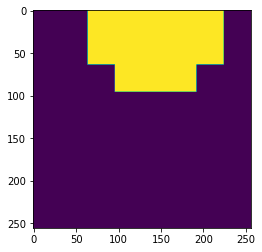

In [ ]:
plt.imshow(masks[0][2])

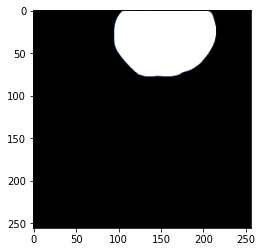

In [ ]:
plt.imshow(np.transpose(dataset_labels[0], axes=(1, 2, 0)))

In [ ]:
import numpy as np

computed_masks = []

for input_data in dataset:
  masks = odin_model.learner.theta_encoder.get_masks(input_data.unsqueeze(0).to(device)).cpu()

  labels = masks[0][0].cpu().numpy()

  labels[labels < 0] = 0
  labels[labels > 0] = 1

  # Revert the mask if "1"s denote the background instead of the main object.
  if len(labels[labels == 1]) > len(labels[labels == 0]):
    labels = 1 - labels

  computed_masks.append(labels)

computed_masks = np.array(computed_masks)

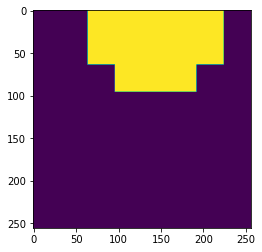

In [ ]:
plt.imshow(computed_masks[0])

In [ ]:
iou = []
for idx, dataset_label in enumerate(dataset_labels):
  if idx < 20:
    # Use only the first channel, since they are similar.
    dataset_label[0][dataset_label[0] < 0] = 0
    dataset_label[0][dataset_label[0] > 0] = 1

    dataset_label = dataset_label[0].cpu().numpy()

    intersection = (np.logical_and(dataset_label, computed_masks[idx])).sum()
    union = (np.logical_or(dataset_label, computed_masks[idx])).sum()
    iou.append(intersection / union)
print(iou)
print(iou[10])
print(np.sum(iou) / len(iou))

[0.5975518173625713, 0.600675929402929, 0.493408203125, 0.49285888671875, 0.49505615234375, 0.49639892578125, 0.6017548571940191, 0.6407130367204197, 0.6044936316366932, 0.6109101160550674, 0.5887456037514655, 0.4779385653409091, 0.587945679813883, 0.5832975756275477, 0.510317876376114, 0.5314973385790326, 0.5280229479258606, 0.541600283235971, 0.5413203149052206, 0.49927737197765715]
0.5887456037514655
0.5511892556937055
